"The varname remains theta throughout!"

In [15]:
import jax
import numpyro
import blackjax
import numpy as np
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam
from numpyro.infer.reparam import TransformReparam
import matplotlib.pyplot as plt

In [16]:
# Model initialization values
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [17]:
def eight_schools():
    mu = numpyro.sample('mu', dist.Normal(2, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    theta = numpyro.sample('theta', dist.Normal(jnp.full(J,mu), tau))
    numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [18]:
rng_key = jax.random.PRNGKey(0)

In [19]:
num_warmup = 500

adapt = blackjax.window_adaptation(
    blackjax.nuts, eight_schools, target_acceptance_rate=0.8
)
(last_state, parameters), intermediate_states, logdensity_fn = adapt.run(rng_key, num_warmup)

New varname: theta
Entered with varname:  theta and centeredness:  [6.8036411e-03 5.5321403e-02 3.3690915e-03 1.4231724e-05 1.8844408e-01
 2.0367986e-01 2.6264443e-04 1.2288201e-01]
New varname: theta_decentered
Entered with varname:  theta and centeredness:  [3.42416205e-02 6.49751499e-02 1.00434745e-05 6.62857071e-02
 3.60433106e-09 3.58419527e-07 8.34514946e-02 4.00610380e-02]
New varname: theta_decentered
Entered with varname:  theta and centeredness:  [2.2771269e-06 2.2794940e-02 7.6983692e-05 3.5606132e-05 2.8885415e-06
 1.0787715e-05 6.2037855e-02 3.3457052e-02]
New varname: theta_decentered
Entered with varname:  theta and centeredness:  [0.03380768 0.05520535 0.02352043 0.04244898 0.01794071 0.01213205
 0.05248682 0.02595032]


In [20]:
# New varname: theta
# Entered with varname:  theta and centeredness:  [6.8036411e-03 5.5321403e-02 3.3690915e-03 1.4231724e-05 1.8844408e-01
#  2.0367986e-01 2.6264443e-04 1.2288201e-01]
# New varname: theta_decentered
# Entered with varname:  theta and centeredness:  [3.42416205e-02 6.49751499e-02 1.00434745e-05 6.62857071e-02
#  3.60433106e-09 3.58419527e-07 8.34514946e-02 4.00610380e-02]
# New varname: theta_decentered
# Entered with varname:  theta and centeredness:  [2.2771269e-06 2.2794940e-02 7.6983692e-05 3.5606132e-05 2.8885415e-06
#  1.0787715e-05 6.2037855e-02 3.3457052e-02]
# New varname: theta_decentered
# Entered with varname:  theta and centeredness:  [0.03380768 0.05520535 0.02352043 0.04244898 0.01794071 0.01213205
#  0.05248682 0.02595032]

In [21]:
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [22]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    extra, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [23]:
num_sample = 1000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [24]:
states[0]

{'mu': Array([ 9.84125996e+00,  8.29757214e+00,  8.88270473e+00,  9.32631779e+00,
         1.11326180e+01,  1.03769350e+01,  5.84292364e+00,  5.26480436e+00,
         6.37275457e+00,  6.74464130e+00,  5.60924339e+00,  7.26118660e+00,
         1.05496502e+01,  1.01521511e+01,  7.29742527e+00,  5.71287680e+00,
         5.72037411e+00,  9.66182137e+00,  8.23744011e+00,  6.56704140e+00,
         6.56327915e+00,  6.07643557e+00,  5.75442076e+00,  4.92685938e+00,
         4.90812874e+00,  4.28522396e+00,  3.11799288e+00,  4.12098742e+00,
         5.99249935e+00,  5.85036802e+00,  5.42901421e+00,  5.37785101e+00,
         4.87338018e+00,  4.51126671e+00,  4.83385181e+00,  5.23995209e+00,
         5.77342749e+00,  4.44265270e+00,  9.67801762e+00,  9.74124050e+00,
         9.27941227e+00,  8.96748734e+00,  9.46567440e+00,  7.97303629e+00,
         8.85469341e+00,  7.61222410e+00,  6.19725418e+00,  6.04276037e+00,
         6.19069624e+00,  3.49988985e+00,  1.71027660e+00,  1.82696629e+00,
      

In [25]:
def scatterplt(samples):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    axes = axes.flatten()
    # reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, best_c)
    # reparam_sample = reparam_sample if reparam else samples['theta'].T
    samples_theta = samples['theta_decentered'].T
    for i in range(8):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'theta_{i}')
        axes[i].set_ylabel('log_std')

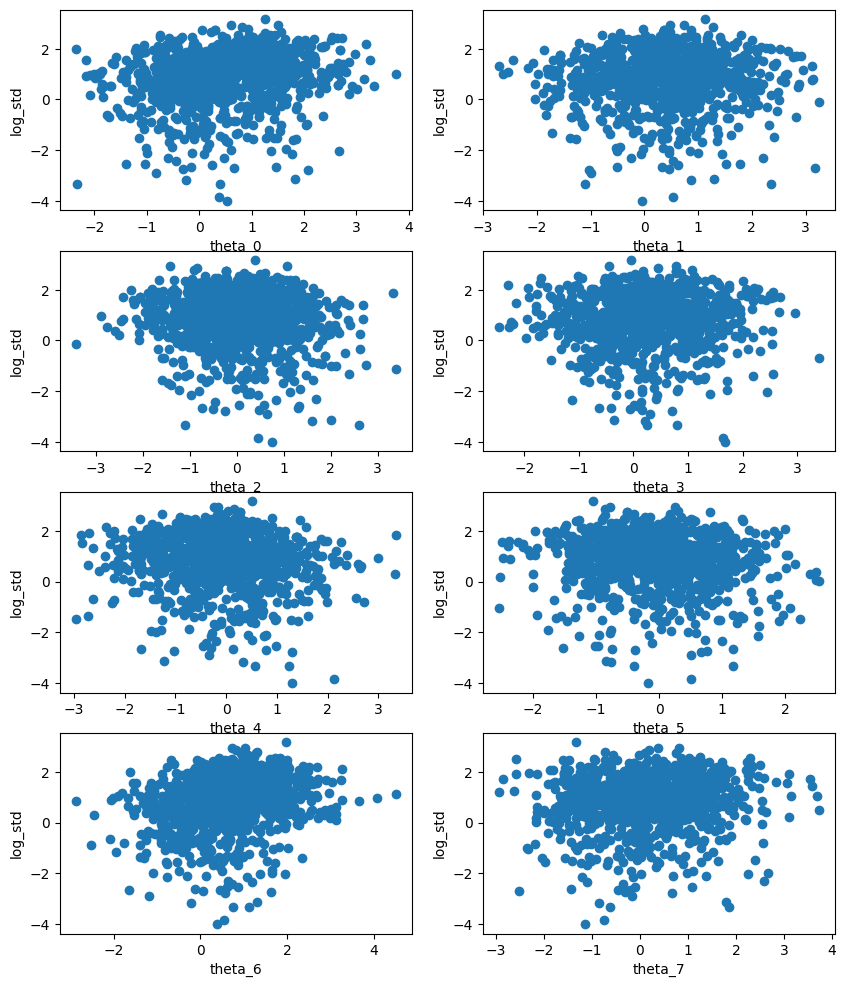

In [26]:
scatterplt(states[0])

In [27]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.89
There were 0.00% divergent transitions


In [28]:
raise ValueError("This is a custom value error.")

ValueError: This is a custom value error.

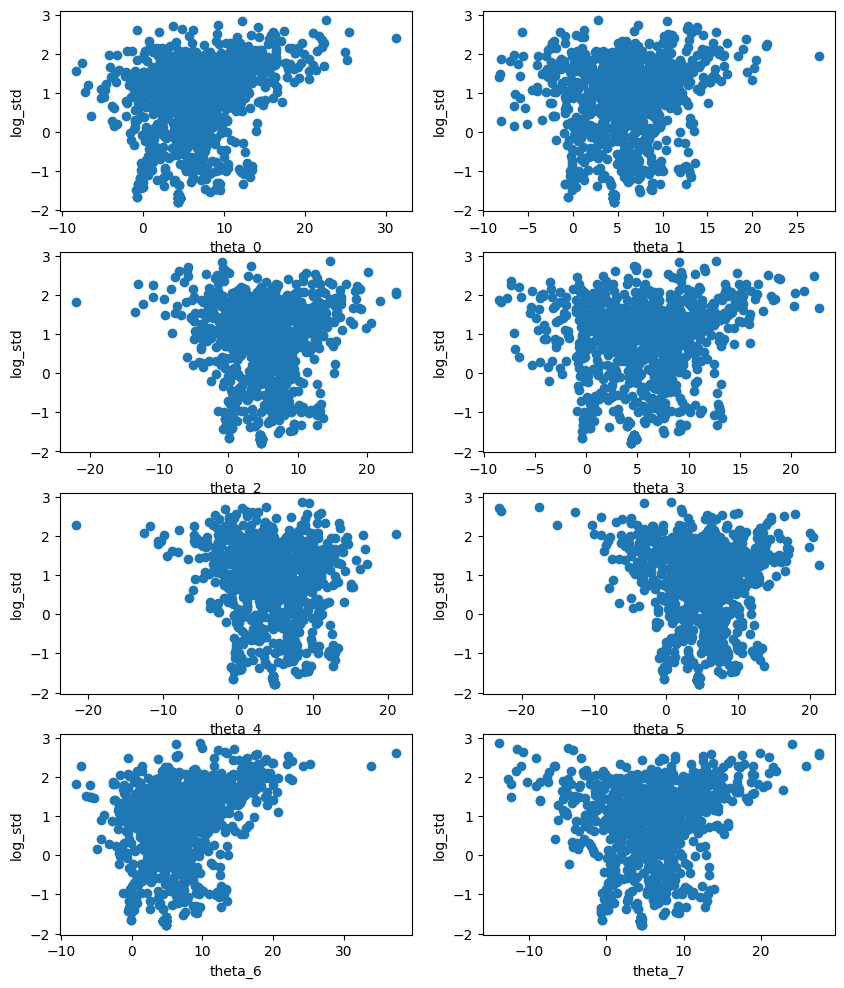

In [ ]:
scatterplt(states[0])

In [ ]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.86
There were 0.10% divergent transitions
